# Analysis of multiumbrella coexsitence simulations

In [20]:
import numpy as np
import matplotlib.pylab as plt
import glob, pickle
from scipy.optimize import curve_fit
from matplotlib import cm
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import scipy.interpolate
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
%config InlineBackend.figure_format = 'retina'


### Load data

In [3]:
def read_colvar_dict(fn):
    
    # Determine fields
    with open(fn,'r') as fp:
        top = fp.readline()
        fields= top.split()[2:]
    
    # Load data columns
    data=np.genfromtxt(fn)
    
    # Create dictionary
    ret = dict()
    for i, field in enumerate(fields):
        ret[field]=data[:,i]
    ret['time_ns']=data[:,0]*500*2/1E6    
    return ret

In [4]:
sims=dict()
for fold in glob.glob('COEX*/*K/'):
    sims[fold] = dict()
    try:
        sims[fold]['COLVAR'] = read_colvar_dict(fold+'COLVAR')
        sims[fold]['DELTAFS'] = np.genfromtxt(fold+'DELTAFS')
        sims[fold]['T'] = float(fold.split('/')[-2].strip('K'))
        sims[fold]['P'] = float(fold.split('/')[-3].replace('COEX_','').strip('bar'))
    except:
        pass
with open('3-coex_2ndbatch.pickle', 'wb') as handle:
    pickle.dump(sims, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
with open('3-coex_2ndbatch.pickle', 'rb') as handle:
    sims = pickle.load(handle)

### Plot time evolution of collective variables

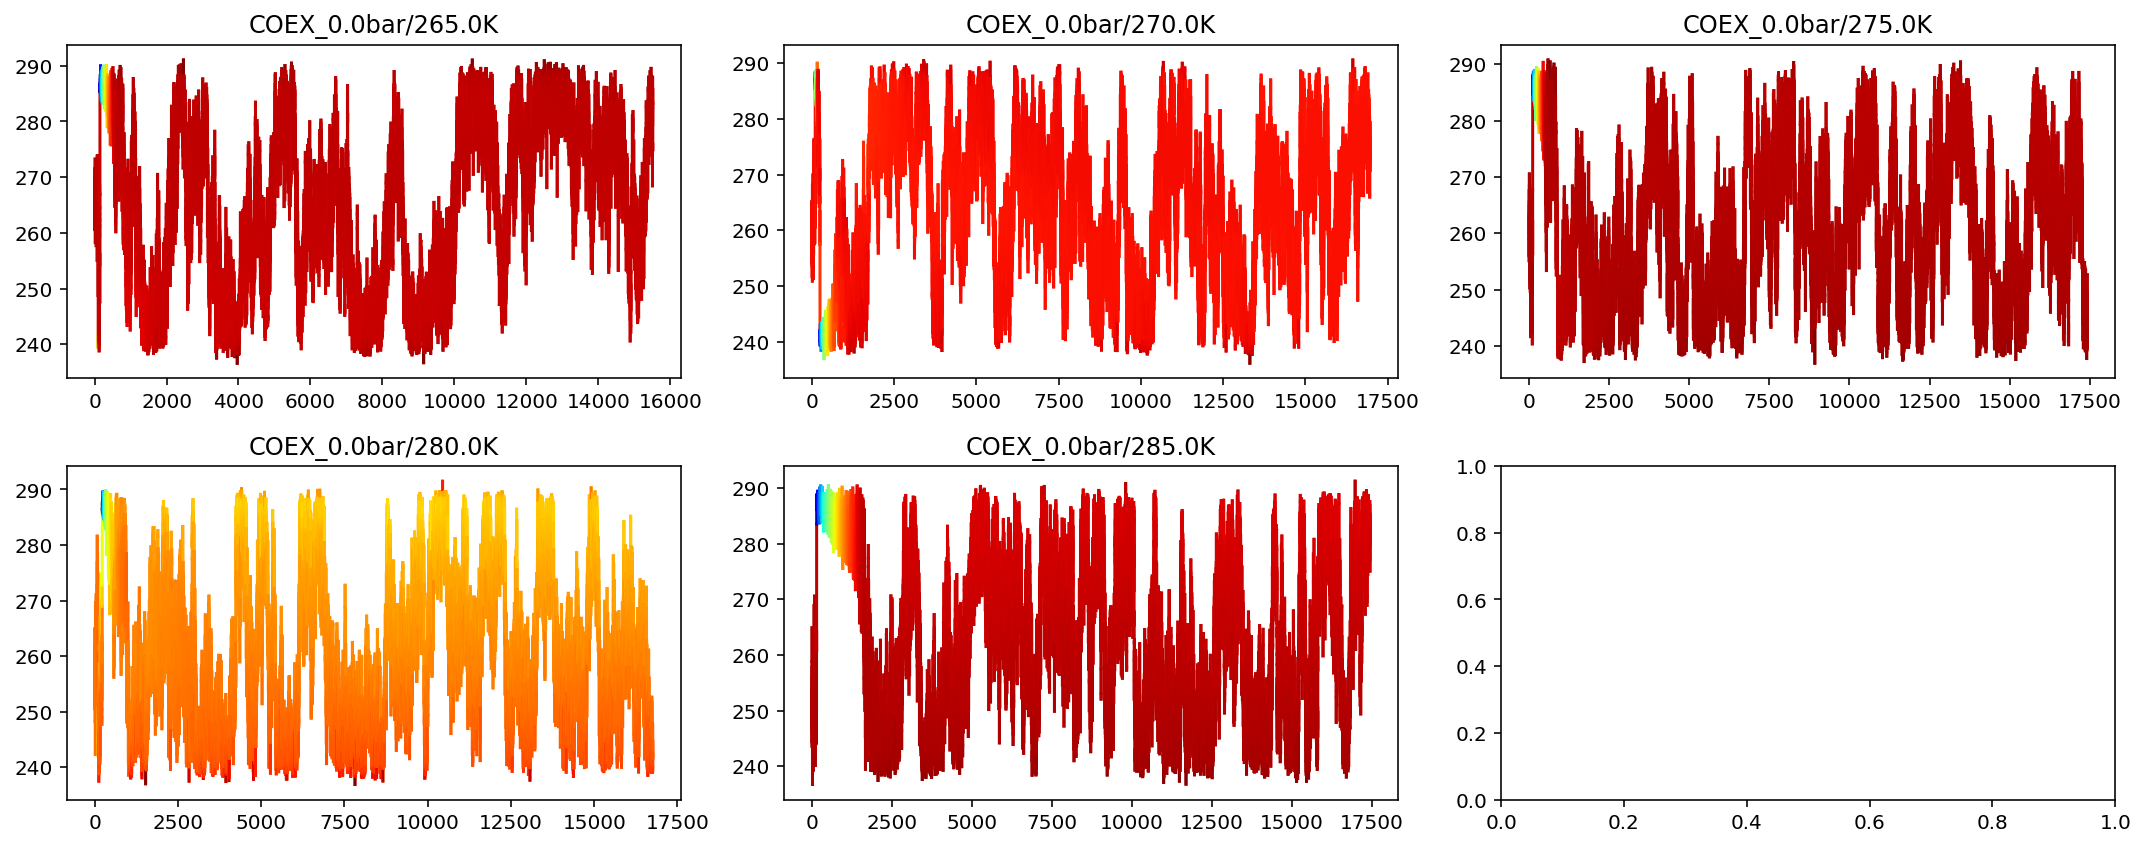

In [20]:
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')
def plot_colourline(ax,x,y,c):
    c = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=c[i])
    return

axs = axs.ravel()
j=0
for i, key in enumerate(sorted(sims.keys())):  
    if '_0.0bar' in key:
        sim=sims[key]
        bias_potential = sim['COLVAR']['opes.bias']
        bias_potential -= bias_potential.min()
        bias_potential=bias_potential/bias_potential[:].max()
        cmap=plt.get_cmap('Spectral')
        norm=plt.Normalize(0.0, 1.0)
       
        plot_colourline(axs[j],sim['COLVAR']['time'], sim['COLVAR']['refcv.morethan'],bias_potential)
        axs[j].title.set_text(key.replace('COEX_1.0bar','').strip('/'))
        j+=1
        
plt.tight_layout()

### Plot of final free energy profile

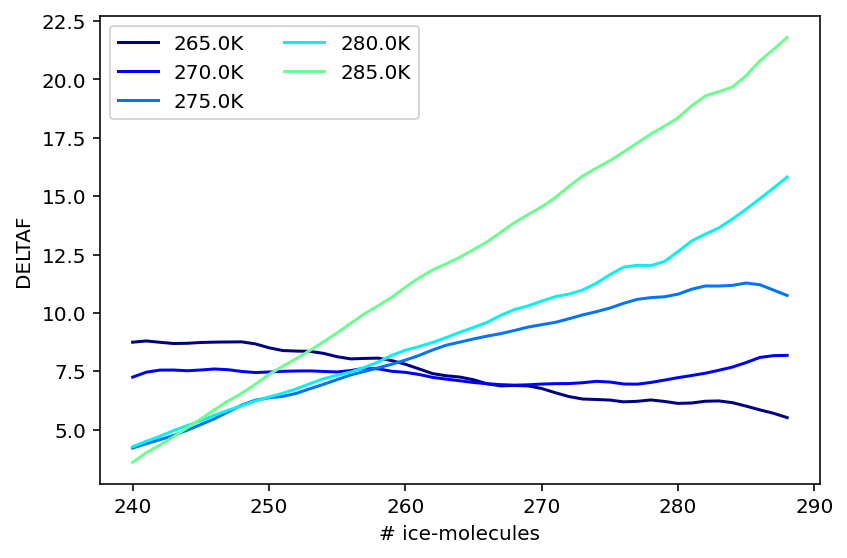

In [21]:
np.arange(240,288,1)
colors = plt.cm.jet(np.linspace(0,0.6,6))
j=0
for i, key in enumerate(sorted(sims.keys())):  
    if '_0.0bar' in key:
        sim=sims[key]
        title=key.replace('COEX_0.0bar','').strip('/')
        plt.plot(np.arange(240,289,1),sim['DELTAFS'][-1,2:],color=colors[j],label=title)
        j+=1
plt.xlabel('# ice-molecules')
plt.ylabel('DELTAF')
plt.legend(ncol=2)       
plt.tight_layout()

### Estimation of chemical potential from collective variables and bias

In [12]:
def linear_fn(x, a, b):
    return a*x + b

In [1]:
#Frames that are excluded
NIGNORE=500

# Color pallete
colors = plt.cm.jet(np.linspace(0,0.6,6))

j=0
chem_pot=[]
for i, key in enumerate(sorted(sims.keys())):  
    if '_0.0bar' in key:
        title=key.replace('COEX_0.0bar','').strip('/')

        # Load data
        sim=sims[key]
        bias_potential = sim['COLVAR']['opes.bias'][NIGNORE:]
        number_of_ice  = sim['COLVAR']['refcv.morethan'][NIGNORE:]
            
        # Create reweighted histogram
        beta = 1./(0.00831441001626*sim['T']) # 1/(kJ/mol)
        logweights = beta*bias_potential
        logweights -= np.amax(logweights)
        bins=48
        histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
        bin_centers = (bin_edges[1:]+bin_edges[:-1])/2

        fes = -(1/beta)*np.log(histo)
        fes -= np.mean(fes)
        
        # Exclude ends with half a bin
        bin_centers=bin_centers[1:-1]
        fes=fes[1:-1]
        plt.scatter(bin_centers,fes,color=colors[j],label=title)

        # Curve fit for linear least squares
        popt, pcov = curve_fit(linear_fn, bin_centers, fes)
        plt.plot(bin_centers, linear_fn(bin_centers,*popt),color=colors[j],)

        # Store chemical potential from slope
        chem_pot.append([sim['T'],popt[0]])
      
        j+=1

plt.xlabel('# ice-molecules')
plt.ylabel(r'G/kJ mol$^{-1}$')
plt.legend(ncol=2)       
plt.tight_layout()

NameError: name 'plt' is not defined

Text(0.5, 0, 'T/K')

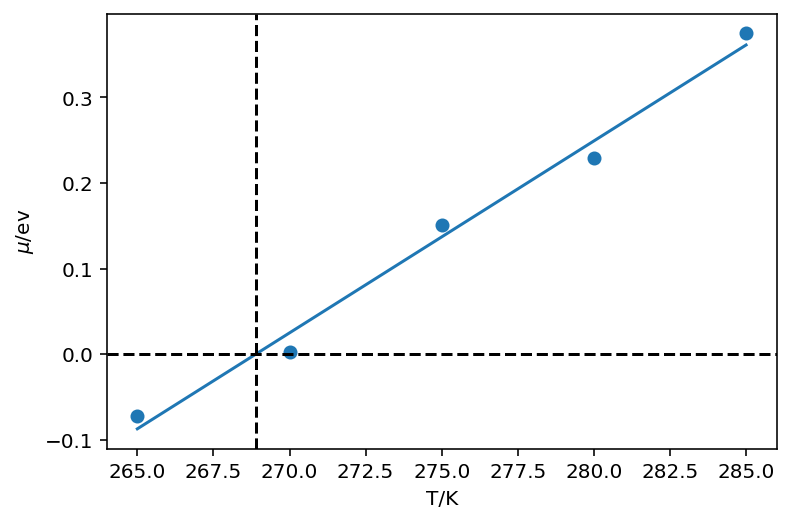

In [24]:
#plt.figure(figsize=(3.2,2.5))
chem_pot = np.array(chem_pot)
popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[0:,1])

plt.scatter(chem_pot[:,0],chem_pot[:,1])
plt.plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))
T_melt=-popt[1]/popt[0]
plt.axhline(y=0.0, linestyle='--',color='k')
plt.axvline(x=T_melt, linestyle='--',color='k')

plt.annotate(r'T$_{\mathrm{melt}}$='+'{:.2f}'.format(T_melt),(260,0.05))
plt.ylabel(r'$\mu$/ev')
plt.xlabel('T/K')

## Analysis for all pressures

### Time evolution of all collective variables

In [7]:
for key in sims.keys():
    sims[key]['NIGNORE']=1000

In [8]:
# First batch
# # remove extra frames for specific simulations
# sims['COEX_1.0bar/275K/']['NIGNORE']=5000
# sims['COEX_1001.0bar/265K/']['NIGNORE']=7500
# sims['COEX_2000.0bar/255K/']['NIGNORE']=5000
# sims['COEX_201.0bar/255K/']['NIGNORE']=8000
# sims['COEX_201.0bar/275K/']['NIGNORE']=4000

In [16]:
# Second batch
# Remove intial frames
sims['COEX_3000.0bar/235.0K/']['NIGNORE']=3000
sims['COEX_3000.0bar/240.0K/']['NIGNORE']=5000

# Remove entirely
sims['COEX_1000.0bar/280.0K/']['NIGNORE']=-1
sims['COEX_2500.0bar/235.0K/']['NIGNORE']=-1

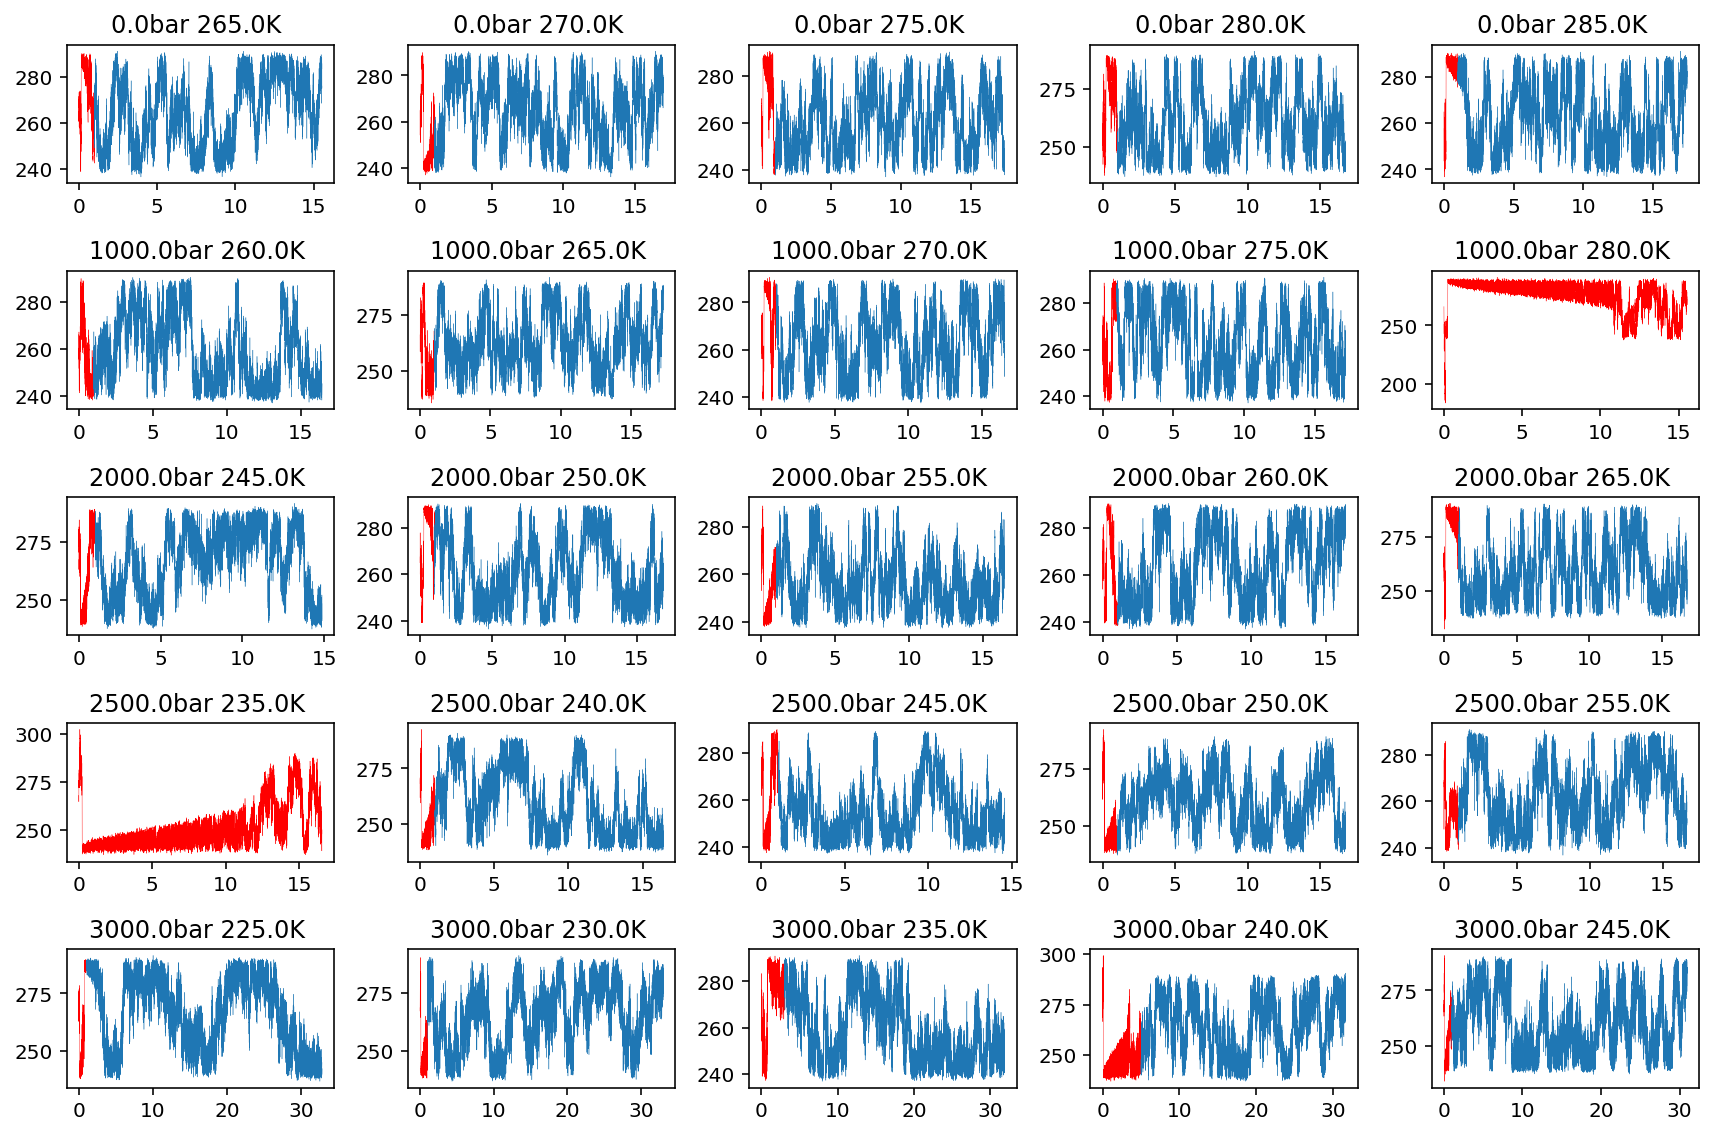

In [17]:
# Plot time evolution of collective variables
fig, axs = plt.subplots(5, 5,figsize=(12,8))
axs=axs.flatten()
i=0
for  key in sorted(sims.keys()):
    if 'COLVAR' in list(sims[key].keys()):
        colvar=sims[key]['COLVAR']
        NIGNORE=sims[key]['NIGNORE']

        axs[i].title.set_text(key.replace('COEX_','').replace('/', ' '))
        if sims[key]['NIGNORE']>0:
            # Part not used for fit
            axs[i].plot(colvar['time_ns'][:NIGNORE],colvar['refcv.morethan'][:NIGNORE],'r',lw=0.2)
            # Part used for fit
            axs[i].plot(colvar['time_ns'][NIGNORE:],colvar['refcv.morethan'][NIGNORE:],lw=0.2)
        else:
            # Whole simulation not used for fit
            axs[i].plot(colvar['time_ns'],colvar['refcv.morethan'],'r',lw=0.2)
        i+=1
        
plt.tight_layout()


In [22]:
IGNORE_BINS=10
sims_result = dict()
for i, key in enumerate(sorted(sims.keys())):  
    # Load data
    sim=sims[key]
    NIGNORE=sim['NIGNORE']
    colvar =sim['COLVAR'] 
    if NIGNORE<0:
        continue
  
    
    try:
        bias_potential = colvar['opes.bias'][NIGNORE:]
        number_of_ice  = colvar['refcv.morethan'][NIGNORE:]
    except:
        continue
    
    # Create reweighted histogram
    beta = 1./(0.00831441001626*sim['T']) # 1/(kJ/mol)
    logweights = beta*bias_potential
    logweights -= np.amax(logweights)
    bins=48
    histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])

    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    
    # Estimate error of bin
    fes_error = (1/beta)*histo_error/histo

    # Exclude ends
    fes=fes[IGNORE_BINS:-IGNORE_BINS]
    bin_centers=bin_centers[IGNORE_BINS:-IGNORE_BINS]
    fes_error=fes_error[IGNORE_BINS:-IGNORE_BINS]

    # Fit linear curve
    popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)

    sims_result[key]=dict()
    sims_result[key]['n_water']=bin_centers
    sims_result[key]['fes']=fes
    sims_result[key]['fes_err']=fes

    sims_result[key]['fes_linear']=linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    sims_result[key]['chem_pot'] = [popt[0],perr]

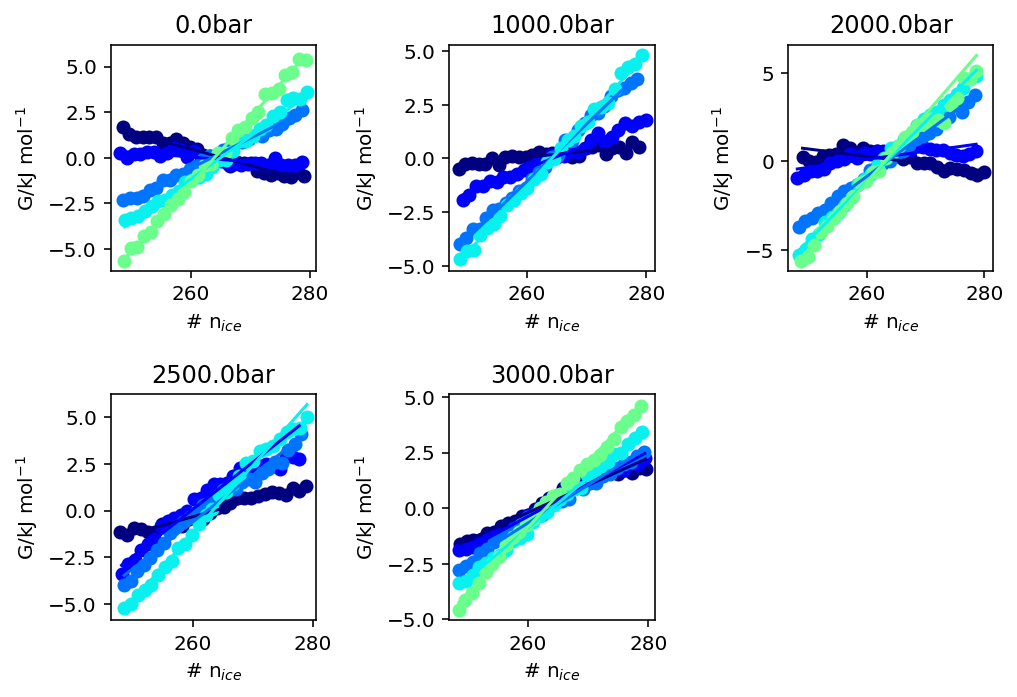

In [23]:
fig, axs = plt.subplots(2, 3,figsize=(7.2,5))
axs=axs.flatten()
press=np.unique([k.split('/')[0] for k in sims_result.keys()])
for i, p in enumerate(press):
    j=0
    for key in sims_result.keys():
        if p in key:
            axs[i].title.set_text(p.strip('COEX_'))
            sim=sims_result[key]
            axs[i].scatter(sim['n_water'],sim['fes'],color=colors[j],label=title)
            axs[i].plot(sim['n_water'],sim['fes_linear'],color=colors[j],label=title)
            j+=1
    axs[i].set_xlabel(r'# n$_{ice}$')
    axs[i].set_ylabel('G/kJ mol$^{-1}$')
#x, y = np.mgrid[1:2, 1:10:0.01]
#plt.imshow(y, cmap=colors, aspect='auto')
#cmap = plt.cm.get_cmap("jet")
#plt.colorbar(colors)
axs[i+1].axis('off')

plt.tight_layout()

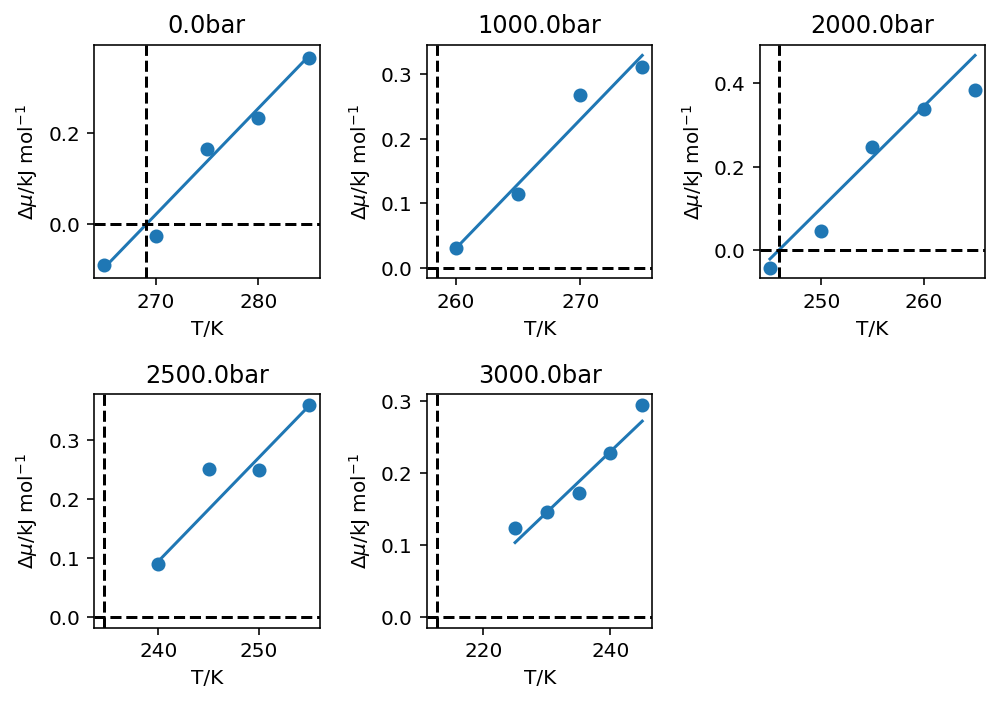

In [25]:
fig, axs = plt.subplots(2, 3,figsize=(7.2,5))
axs=axs.flatten()
coex_line=[]
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result.keys():
        if p in key:
            
            sim=sims_result[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])

    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    coex_line.append([float(p.strip('COEX_bar')),T_melt])
    axs[i].title.set_text(p.strip('COEX_'))
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\Delta\mu$/kJ mol$^{-1}$')
    axs[i].set_xlabel('T/K')
    
coex_line=np.array(coex_line)
coex_line=coex_line[np.argsort(coex_line[:,0])]
axs[i+1].axis('off')
plt.tight_layout()

### Store melting data

In [50]:
with open('P_T.dat','w') as fp:
    fp.write('#{:14}{:15}'.format('pressure/bar','T/K'))
    for c in coex_line:
        fp.write('\n{:<15.0f}{:<15.1f}'.format(c[0],c[1]))
!cat P_T.dat

#pressure/bar  T/K            
0              269.1          
1000           258.5          
2000           245.9          
2500           234.6          
3000           212.7          

### Clausius Clapeyron analysis

According to [wikipedia](https://en.wikipedia.org/wiki/Clausius%E2%80%93Clapeyron_relation#Definition) the Clausius-Clapeyron euqation is given by:
\begin{equation}\frac{dP}{dT}=\frac{\Delta h}{\Delta v T},\end{equation}
where $P$ and $T$ are the pressure and the temperature at the melting point, and $\Delta v$ and $\Delta h$ are the changes in enthalpy and volume between the two phases.

In [51]:
def extract_form_log(fn):
    lines=open(fn,'r').readlines()
    start=np.where([('Step' in l) for l in lines])[-1][0]
    data={keyi.lower(): []  for keyi in lines[start].split()}
    for l in lines[start+1:]:
        ls=l.split()
        if ls[0].isdigit():
            for i, key in enumerate(data.keys()):
                try:
                    data[key].append(float(ls[i]))
                except:
                    pass
        else:
            break
    for key in data.keys():
        data[key]=np.array(data[key])
    return data

In [52]:
# log_clausius=dict()
# for fold in glob.glob('Clausius/*K/'):
#     log_clausius[fold] = extract_form_log(fold+'/log.lammps')
# with open('Clausius_2nd_batch.pickle', 'wb') as handle:
#     pickle.dump(log_clausius, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
with open('Clausius_2nd_batch.pickle', 'rb') as handle:
    log_clausius = pickle.load(handle)

In [54]:
# Melting curve with derivative
T_P_DPDT = []
NIGNORE=200
# REMEMBER MISTAKE OF LAMMPS USING ATMOSPHERE AND NOT BAR

# Unique pressures and temperature names
TP_str=list(set([tp.split('_')[-1] for tp in log_clausius.keys()]))
TP_str=([sorted([t for t in log_clausius.keys() if tp in t]) for tp in TP_str])

for tp in TP_str:
    liquid= []
    h_iceIh  = np.mean(log_clausius[tp[0]]['enthalpy'][NIGNORE:])
    v_iceIh  = np.mean(log_clausius[tp[0]]['volume'][NIGNORE:])
    h_liquid = np.mean(log_clausius[tp[1]]['enthalpy'][NIGNORE:])
    v_liquid = np.mean(log_clausius[tp[1]]['volume'][NIGNORE:])
    
    # Change in volume from iceIh to Liquid
    dv=v_liquid-v_iceIh #Å^3
    dv_si = dv*1E-10**3 #m^3
    
    # Change in enthalpy from iceIh to Liquid
    dh=h_liquid-h_iceIh #kcal/mol
    dh_si = dh*6.9477E-21

    
    P=float(tp[0].split('_')[-1].split('bar')[0])
    T=float(tp[0].split('_')[-1].split('bar')[1].strip('K/'))
    DPDT_si = (dh_si)/(dv_si*T)
    
    # Store terms for Clausius Clapeyron
    T_P_DPDT.append([T,P,DPDT_si/101325])

T_P_DPDT=np.array(T_P_DPDT)


T_P_DPDT=T_P_DPDT[np.argsort(T_P_DPDT[:,0])]

melting_line_splines = scipy.interpolate.CubicHermiteSpline(T_P_DPDT[:,0],T_P_DPDT[:,1],dydx=T_P_DPDT[:,2])#,bc_type='natural')

### Plot phase diagram

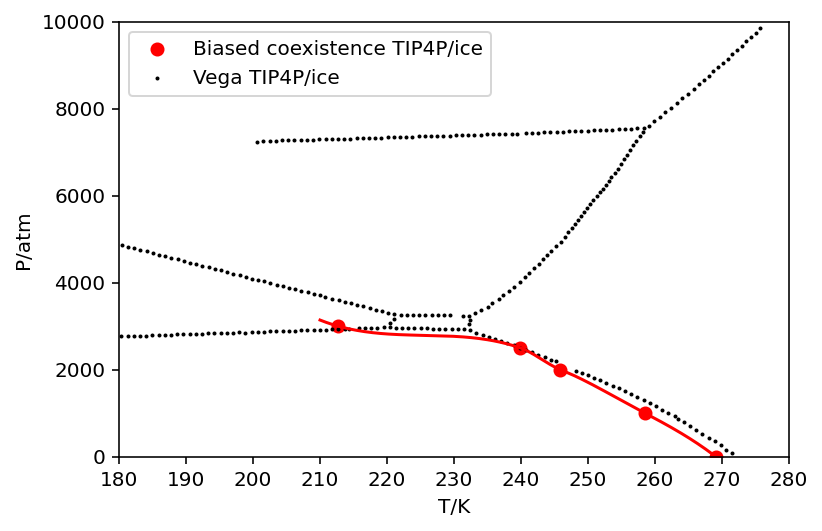

In [60]:
#exp_data=np.genfromtxt('exp_iceIh_liquid.csv')
tip4p_vega_data=np.genfromtxt('tip4p_ice_pd.dat')

# Convert from MPa to bar
#exp_data[:,1]=exp_data[:,1]*10*0.986923
#exp_data=exp_data[np.argsort(exp_data[:,1])]
tip4p_vega_data[:,1]=tip4p_vega_data[:,1]*10*0.986923

plt.scatter(T_P_DPDT[:,0],T_P_DPDT[:,1],color='r',label='Biased coexistence TIP4P/ice')
t_range=np.linspace(210,270,200)
plt.plot(t_range,melting_line_splines(t_range),color='r')
plt.scatter(tip4p_vega_data[:,0],tip4p_vega_data[:,1],label='Vega TIP4P/ice',s=1,color='k')
#plt.plot(exp_data[:,0],exp_data[:,1],label='Experimental')
plt.xlabel('T/K')
plt.ylabel('P/atm')
plt.legend()
plt.xlim([180,280])
plt.ylim([0,10000])
a=plt.xticks(np.arange(180,290,10))     

## Supplementary analysis

### Plot time evolution of free energy profile

In [ ]:
np.arange(240,288,1)
colors = plt.cm.jet(np.linspace(0,0.6,6))
fig, axs = plt.subplots(2,3, figsize=(15, 6), facecolor='w', edgecolor='k')

axs = axs.ravel()

j=0
for i, key in enumerate(sorted(sims.keys())):  
    if '_0.0bar' in key:
        sim=sims[key]
        title=key.replace('COEX_1.0bar','').strip('/')
        axs[j].title.set_text(key.replace('COEX_1.0bar','').strip('/'))
        axs[j].contourf((sim['DELTAFS'][:,2:]),levels=1000)#,label=title)
        axs[j].set_ylabel('# itterations')
        j+=1
plt.tight_layout()

### Time evolution for Clausius-Clapeyron simulations


In [ ]:
fig, axs = plt.subplots(2,2)#, figsize=(15, 6), facecolor='w', edgecolor='k')
axs = axs.ravel()

for tp in TP_str:
    liquid= []
    h_iceIh  = log_clausius[tp[0]]['enthalpy']
    v_iceIh  = log_clausius[tp[0]]['volume']
    h_liquid = log_clausius[tp[1]]['enthalpy']
    v_liquid = log_clausius[tp[1]]['volume']
    
    # Enthalpy
    axs[0].plot(log_clausius[tp[0]]['step'],log_clausius[tp[0]]['enthalpy'])
    axs[1].plot(log_clausius[tp[0]]['step'],log_clausius[tp[1]]['enthalpy'])
    
    # Volume
    axs[2].plot(log_clausius[tp[0]]['step'],log_clausius[tp[0]]['volume'])
    axs[3].plot(log_clausius[tp[0]]['step'],log_clausius[tp[1]]['volume'])
    
plt.tight_layout()

## Alternative analysis using refcv2

In [ ]:
# Plot time evolution of collective variables
fig, axs = plt.subplots(5, 5,figsize=(12,8))
axs=axs.flatten()
i=0
for  key in sorted(sims.keys()):
    if 'COLVAR' in list(sims[key].keys()):
        colvar=sims[key]['COLVAR']
        NIGNORE=sims[key]['NIGNORE']

        axs[i].title.set_text(key.replace('COEX_','').replace('/', ' '))
        if sims[key]['NIGNORE']>0:
            # Part not used for fit
            axs[i].plot(colvar['time_ns'][:NIGNORE],colvar['refcv2.morethan'][:NIGNORE],'r',lw=0.2)
            # Part used for fit
            axs[i].plot(colvar['time_ns'][NIGNORE:],colvar['refcv2.morethan'][NIGNORE:],lw=0.2)
        else:
            # Whole simulation not used for fit
            axs[i].plot(colvar['time_ns'],colvar['refcv2.morethan'],'r',lw=0.2)
        i+=1
        
plt.tight_layout()


In [ ]:
IGNORE_BINS=10
sims_result2 = dict()
for i, key in enumerate(sorted(sims.keys())):  
   # if '2500' in key:
   #     continue
    sim=sims[key]
    NIGNORE=sim['NIGNORE']
    colvar =sim['COLVAR'] 
    if NIGNORE<0:
        continue
    # Load data
    sim=sims[key]
    try:
        bias_potential = colvar['opes.bias'][NIGNORE:]
        number_of_ice  = colvar['refcv2.morethan'][NIGNORE:]
    except:
        continue
    
    # Create reweighted histogram
    beta = 1./(0.00831441001626*sim['T']) # 1/(kJ/mol)
    logweights = beta*bias_potential
    logweights -= np.amax(logweights)
    bins=48
    try:
        histo, bin_edges = np.histogram(number_of_ice,weights=np.exp(logweights),bins=bins)
    except:
        continue
    histo_error = np.sqrt(np.histogram(number_of_ice, bins=bins, weights=np.exp(logweights)**2)[0])

    bin_centers = (bin_edges[1:]+bin_edges[:-1])/2
    fes = -(1/beta)*np.log(histo)
    fes -= np.mean(fes)
    
    # Estimate error of bin
    fes_error = (1/beta)*histo_error/histo

    # Exclude ends
    fes=fes[IGNORE_BINS:-IGNORE_BINS]
    bin_centers=bin_centers[IGNORE_BINS:-IGNORE_BINS]
    fes_error=fes_error[IGNORE_BINS:-IGNORE_BINS]

    # Fit linear curve
    try:
        popt, pcov = curve_fit(linear_fn, bin_centers, fes, sigma=fes_error)
    except:
        continue
    sims_result2[key]=dict()
    sims_result2[key]['n_water']=bin_centers
    sims_result2[key]['fes']=fes
    sims_result2[key]['fes_err']=fes

    sims_result2[key]['fes_linear']=linear_fn(bin_centers,*popt)
    perr = np.sqrt(np.diag(pcov))[0]
    #print(key,perr)
    sims_result2[key]['chem_pot'] = [popt[0],perr]

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(7.2,5))
axs=axs.flatten()
press=np.unique([k.split('/')[0] for k in sims_result.keys()])
for i, p in enumerate(press):
    j=0
    for key in sims_result2.keys():
        if p in key:
            axs[i].title.set_text(p.strip('COEX_'))
            sim=sims_result2[key]
            axs[i].scatter(sim['n_water'],sim['fes'],color=colors[j])#,label=title)
            axs[i].plot(sim['n_water'],sim['fes_linear'],color=colors[j])#,label=title)
            j+=1
    axs[i].set_xlabel('# ice-molecules')
    axs[i].set_ylabel('F/ev')
            
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(2, 3,figsize=(7.2,5))
axs=axs.flatten()
coex_line=[]
for i, p in enumerate(press):
    j=0
    chem_pot=[]
    for key in sims_result2.keys():
        if p in key:
            
            sim=sims_result2[key]
            chem_pot.append([sims[key]['T'], sim['chem_pot'][0],sim['chem_pot'][1]])
    chem_pot = np.array(chem_pot)
    popt, pcov = curve_fit(linear_fn, chem_pot[:,0], chem_pot[:,1],sigma=chem_pot[:,2])

    axs[i].scatter(chem_pot[:,0],chem_pot[:,1])
    axs[i].plot(chem_pot[:,0],linear_fn(chem_pot[:,0],*popt))

    T_melt=-popt[1]/popt[0]
    coex_line.append([float(p.strip('COEX_bar')),T_melt])
    axs[i].title.set_text(p.strip('COEX_'))
    axs[i].axhline(y=0.0, linestyle='--',color='k')
    axs[i].axvline(x=T_melt, linestyle='--',color='k')
    axs[i].set_ylabel(r'$\mu$/ev')
    axs[i].set_xlabel('T/K')
coex_line=np.array(coex_line)
coex_line=coex_line[np.argsort(coex_line[:,0])]
plt.tight_layout()

In [ ]:
with open('P_T_2.dat','w') as fp:
    fp.write('#{:14}{:15}'.format('pressure/bar','T/K'))
    for c in coex_line:
        fp.write('\n{:<15.0f}{:<15.1f}'.format(c[0],c[1]))
!cat P_T_2.dat
!cat P_T.dat

### Plot phase diagram

In [ ]:
P_T_2nd = np.genfromtxt('P_T_2.dat')
#exp_data=np.genfromtxt('exp_iceIh_liquid.csv')
tip4p_vega_data=np.genfromtxt('tip4p_ice_pd.dat')
# Convert from MPa to bar
#exp_data[:,1]=exp_data[:,1]*10*0.986923
#exp_data=exp_data[np.argsort(exp_data[:,1])]
tip4p_vega_data[:,1]=tip4p_vega_data[:,1]*10*0.986923

plt.scatter(T_P_DPDT[:,0],T_P_DPDT[:,1],color='r',label='Biased coexistence TIP4P/ice')
t_range=np.linspace(210,270,200)
plt.plot(t_range,melting_line_splines(t_range),color='r')
plt.scatter(tip4p_vega_data[:,0],tip4p_vega_data[:,1],label='Vega TIP4P/ice',s=1,color='k')
print(P_T_2nd[:,0])
print(P_T_2nd[:,1])
plt.scatter(P_T_2nd[:,1],P_T_2nd[:,0],color='b',label='Biased coexistence TIP4P/ice refcv2')
#plt.plot(exp_data[:,0],exp_data[:,1],label='Experimental')

plt.xlabel('T/K')
plt.ylabel('P/atm')
plt.legend()
plt.xlim([180,280])
plt.ylim([0,10000])
a=plt.xticks(np.arange(180,290,10))     

## Visualize simulation box

In [ ]:
import nglview, MDAnalysis
import MDAnalysis.transformations


In [ ]:
u = MDAnalysis.Universe('COEX_0.0bar/265.0K/water.data','COEX_0.0bar/265.0K/dump.dcd',in_memory=True)
typ={'2':'O', '1':'H'}

u.atoms.types=[typ[t] for t in u.atoms.types]
u.add_TopologyAttr('names')
u.atoms.names=u.atoms.types

In [ ]:
transform = MDAnalysis.transformations.unwrap(u.atoms)
u.trajectory.add_transformations(transform)

In [ ]:
with MDAnalysis.Writer("water_unwrapped.xtc", u.atoms) as W:
    for ts in u.trajectory:
        W.write(u.atoms)

In [ ]:
with MDAnalysis.Writer("water_unwrapped.pdb") as pdb:
    pdb.write(u.atoms)

In [ ]:
#ag = u.atoms
#transform = MDAnalysis.transformations.unwrap(ag)
#u.trajectory.add_transformations(transform)

In [ ]:

#u.atoms.types


In [ ]:
#u.atoms[0]

In [ ]:

view = nglview.show_mdanalysis(u)
view.camera = 'orthographic'
#view.add_unitcell()
#view.control.orient([1,1,1])
view.add_representation(repr_type='cartoon')#, selection=[i for i in range(100)], color='red')
#view.color_by('type')
#print(view.showow_mdanalysis)
#view.add_representation('ball')
#view.add_representation('fcsd', selection=[i for i in range(100)], color='red')
#view.add_ball
view.control.rotate(
    MDAnalysis.lib.transformations.quaternion_from_euler(
        np.pi/2,   np.pi/2, np.pi/2, 'ryzy').tolist())
view.control.zoom(0.6)

#view.color_by('type')
view
#view.color_by('atomindex')


In [ ]:
from nglview.contrib.movie import MovieMaker

movie = MovieMaker(view, fps=24, output='movie.gif')
movie.make()

In [ ]:
nglview.__version__